## First look at UGC993

Finding emission lines and calculating redshift

In [73]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import specutils
import astropy.units as u

from astropy.io import fits

from specutils import Spectrum1D, SpectralRegion
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from astropy.nddata import StdDevUncertainty
from specutils.fitting import find_lines_threshold

from astropy.modeling import models

In [2]:
ugc993 = fits.open('UGC993.fits')

In [4]:
header = ugc993[1].header


In [5]:
wavelength = np.arange(header['CRVAL3'], header['CRVAL3'] + header['CD3_3'] * header['NAXIS3'], header['CD3_3'])

fluxCube = ugc993[1].data
errorCube = ugc993[2].data

In [6]:
whiteImage = np.nansum(fluxCube, axis=0)

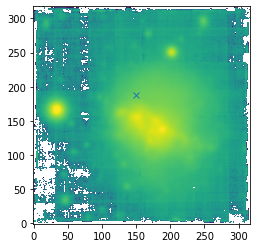

In [7]:
plt.imshow(whiteImage, origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1e6));

plt.plot(150, 188, 'x')

# plt.ylim(100, 200)
# plt.xlim(100, 200);

54.043476


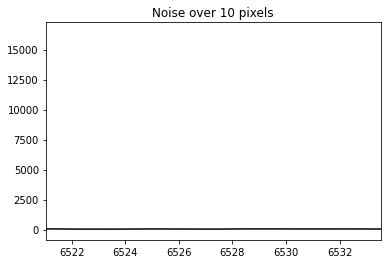

In [8]:
plt.plot(wavelength, fluxCube[:, 150, 188], 'k-');
plt.xlim(6521.03515625, 6533.53515625)
plt.title('Noise over 10 pixels')


print(np.mean(fluxCube[1417:1427, 150, 188]))


# Searching for lines by hand

(4750.0, 4900.0)

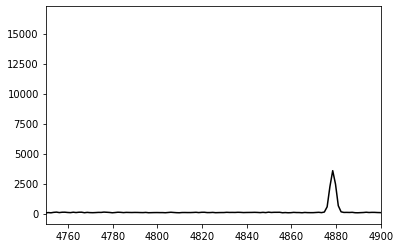

In [9]:
plt.plot(wavelength, fluxCube[:, 150, 188], 'k-');
plt.xlim(4750, 4900)

In [11]:
print(f'Search for maximum at wavelength less than {wavelength[120]} Angstrom')
print(f'Peak at {wavelength[np.where(fluxCube[:, 150, 188]==fluxCube[0:120, 150, 188].max())]} Angstrom')

Search for maximum at wavelength less than 4899.78515625 Angstrom
Peak at [4878.53515625] Angstrom


(4900.0, 5000.0)

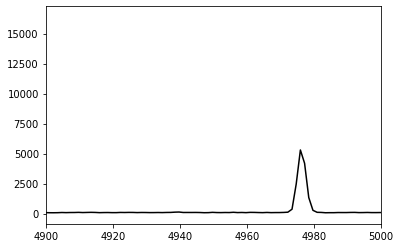

In [12]:
plt.plot(wavelength, fluxCube[:, 150, 188], 'k-');
plt.xlim(4900, 5000)

In [13]:
print(f'Search for maximum at wavelength less than {wavelength[200]} Angstrom')
print(f'Peak at {wavelength[np.where(fluxCube[:, 150, 188]==fluxCube[0:210, 150, 188].max())]} Angstrom') 

Search for maximum at wavelength less than 4999.78515625 Angstrom
Peak at [4976.03515625] Angstrom


(4750.0, 5100.0)

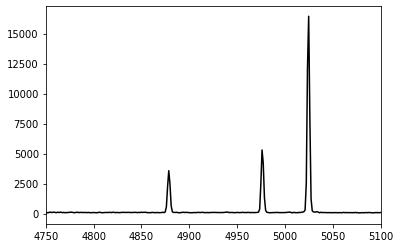

In [14]:
plt.plot(wavelength, fluxCube[:, 150, 188], 'k-');
plt.xlim(4750, 5100)

In [15]:
print(f'Maximum')
print(f'Peak at {wavelength[np.where(fluxCube[:, 150, 188]==fluxCube[:, 150, 188].max())]} Angstrom')

Maximum
Peak at [5024.78515625] Angstrom


(6579.78515625, 6591.03515625)

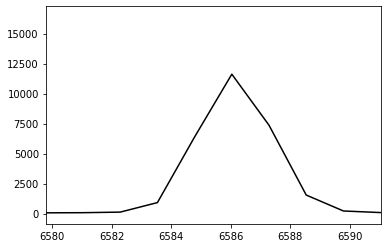

In [16]:
plt.plot(wavelength, fluxCube[:, 150, 188], 'k-');
plt.xlim(6579.78515625, 6591.03515625)

In [17]:
print(f'Search for maximum at wavelength greater than {wavelength[1400]} Angstrom')
print(f'Peak at {wavelength[np.where(fluxCube[:, 150, 188]==fluxCube[1400:1480, 150, 188].max())] } Angstrom') 


Search for maximum at wavelength greater than 6499.78515625 Angstrom
Peak at [6586.03515625] Angstrom


## Estimated emission line wavelengths

4878.53515625

4976.03515625

5024.7851562

6586.03515625



#### From SDSS:

H Beta - 4862.68

O III - 4960.295

O III - 5008.240

H alpha - 6564.61

In [18]:
#Wavelengths = [H beta, O III, O III, H alpha]
labs = np.array([4862.68, 4960.295, 5008.240, 6564.61])
observed = np.array([4878.53515625, 4976.03515625, 5024.7851562, 6586.03515625])


In [19]:
def redshift(lab, observed):
    '''
    Function to calculate redshift
    '''
    return (observed - lab)/lab

In [20]:
redshifts = np.zeros(4)

for i in range(len(labs)):
    redshifts[i] = (redshift(labs[i], observed[i]))

print(f'Mean calculated redshifts: {np.mean(redshifts):.5}')

Mean calculated redshifts: 0.0032503


(6500.0, 6600.0)

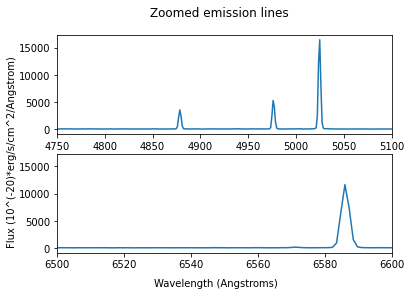

In [21]:
fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('Zoomed emission lines')

fig.text(0.35, 0.01, 'Wavelength (Angstroms)')
fig.text(0.01, 0.15, 'Flux (10^(-20)*erg/s/cm^2/Angstrom)', rotation='vertical')

ax1.plot(wavelength, fluxCube[:, 150, 188])
ax1.set_xlim(4750, 5100)
ax2.plot(wavelength, fluxCube[:, 150, 188])
ax2.set_xlim(6500, 6600)

# Specutils

Need to redefine the spectra in terms of specutils/astropy quantities

In [135]:
lamb = wavelength * u.AA 
flux = fluxCube[:, 150, 188]* 10**-20 * u.Unit('erg cm-2 s-1 AA-1')

spec = Spectrum1D(spectral_axis = lamb, flux=flux, 
                  uncertainty = StdDevUncertainty(np.sqrt(errorCube[:, 150, 188])* 10**-20))

print(spec.shape)

(3681,)


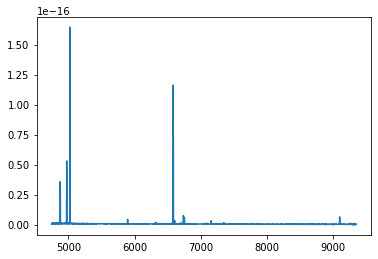

In [23]:
f, ax = plt.subplots()  

ax.step(spec.spectral_axis, spec.flux) 

# Searching for lines with specutils

In [181]:
lines = find_lines_threshold(spec, noise_factor= 50)  
#lines = find_lines_threshold(spec, flux_threshold=0.25)

#lines[lines['line_type'] == 'emission']  

lines

line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4878.53515625,emission,103
4976.03515625,emission,181
5024.78515625,emission,220
6586.03515625,emission,1469


In [50]:
spec_obs = lines['line_center']#[0]

spec_redshift = redshift(labs*u.AA, spec_obs)

print(spec_redshift)
print(f'Mean calculated redshift: {np.mean(spec_redshift)}')


[0.00326058 0.00317323 0.00330359 0.00326374]
Mean calculated redshift: 0.0032502832416161373


## Find and subtract noise 

no lines between 10 angstrom range:

6520, 6530


In [51]:
halphaNoise = (fluxCube[1417:1427])


(318, 317)


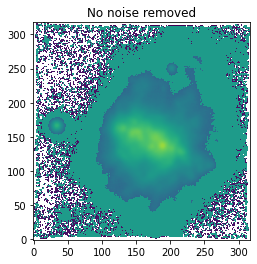

In [52]:
halphaImage = np.nansum(fluxCube[1464:1474], axis=0)
print(halphaImage.shape)

plt.imshow(halphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1e6));
plt.title('No noise removed')
plt.contourf(halphaImage, levels=[1, 10, 100])



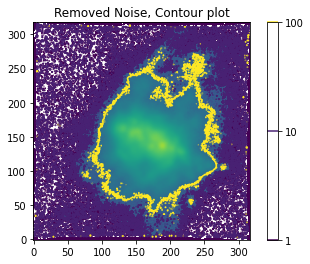

In [159]:
#Removing background noise from spectrum

HalphaImage = np.nansum((fluxCube[1464:1474] - halphaNoise), axis=0)

plt.title('Removed Noise, Contour plot')
plt.imshow(HalphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1e6));

plt.contour(HalphaImage, levels=[1, 10, 100])
plt.colorbar()

#### Masked cubes

In [105]:
Flux250 = fluxCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Flux100 = fluxCube[:, np.array(np.where(HalphaImage >= 100))[0], np.array(np.where(HalphaImage >= 100))[1]]
Flux10 = fluxCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

In [117]:
print(Flux250.shape)

print(len(Flux250[3]))

(3681, 16134)
16134


In [106]:
Error250 = errorCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Error100 = errorCube[:, np.array(np.where(HalphaImage >= 100))[0], np.array(np.where(HalphaImage >= 100))[1]]
Error10 = errorCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

Can now start trying to fit for the masked values

## Question

am I fitting gaussian to the 10 pixel length?

Text(0.5, 1.0, 'H-alpha line, 10 pixels')

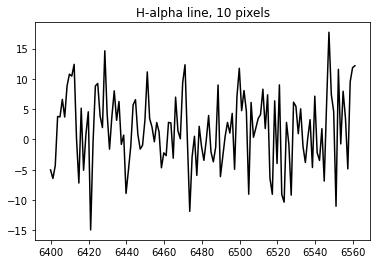

In [395]:
plt.plot(wavelength[1320:1450], fluxCube[1320:1450, 150, 188] - np.mean(halphaNoise[:, 150, 188]), 'k-');
#plt.xlim(6500.78515625, 6600.03515625)
plt.title('H-alpha line, 10 pixels')


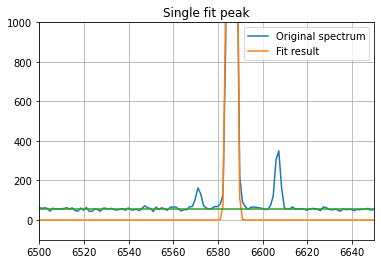

In [407]:
from astropy.modeling import models, fitting

spectrum = Spectrum1D(flux = fluxCube[1464:1474, 150, 188] * u.Unit('erg cm-2 s-1 AA-1'),
                      spectral_axis=wavelength[1464:1474]*u.AA)

sub_region = SpectralRegion(6580*u.AA, 6600*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)

#print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

#continuum = models.Polynomial1D(1, window = (6220*u.AA, 6240*u.AA))

# fit the data with the fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

continuum_init = fit(models.Polynomial1D(1), wavelength[1320:1455], fluxCube[1320:1455, 150, 188])
cont_fit = continuum_init(wavelength)

g_init = models.Gaussian1D(amplitude=11618.8974609375 * u.Unit('erg cm-2 s-1 AA-1'),
                           mean=6586.131866895034*u.AA, stddev=1.305720229701005*u.AA) 

g_fit = fit_lines(spectrum, g_init, window=(6580*u.AA, 6600*u.AA))
y_fit = g_fit(wavelength*u.AA) 


# Plot the original spectrum and the fitted.
plt.plot(wavelength, fluxCube[:, 150, 188], label="Original spectrum")
plt.plot(wavelength, y_fit, label="Fit result")
plt.plot(wavelength, cont_fit)
plt.title('Single fit peak')
plt.xlim(6500, 6650)
plt.grid(True)

plt.ylim(-100, 1000)
plt.legend()



In [224]:
sub_region = SpectralRegion(6570*u.AA, 6600*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)

#print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

estimates = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

print(np.float64(estimates.amplitude))

print(estimates.amplitude)
print(estimates.mean)
print(estimates.stddev)



11618.8974609375
Parameter('amplitude', value=11618.8974609375, unit=erg / (Angstrom cm2 s))
Parameter('mean', value=6586.131866895034, unit=Angstrom)
Parameter('stddev', value=1.305720229701005, unit=Angstrom, bounds=(1.1754943508222875e-38, None))


Need to be better at commenting code / making it neater / labels on graphs

matplotlib style?

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams['axes.facecolor'] = 'none'

## Function

Use contour lines H alpha to get pixels that will be used in an array

input array wavelength, flux

In function:

Plot spectrum

Find lines

Calculate redshift

Fit lines


In [334]:
def function(wavelength, flux, error):
    
    print(len(flux[:, 0]))
    
    #Write spectrum astropy way and plot spectrum
    #=======================================================================
    specutils.conf.do_continuum_function_check = False
    
    lamb = wavelength * u.AA 
    flux = flux * u.Unit('erg cm^-2 s^-1 AA^-1')
    spec = Spectrum1D(spectral_axis = lamb, flux=flux, 
                  uncertainty = StdDevUncertainty(np.sqrt(error)* 10**-20))
    
    f, ax = plt.subplots()  

    ax.step(spec.spectral_axis, np.reshape(spec.flux, (3681, len(flux[:, 0]))))
    
    
    #Find lines and calculate redshift
    #========================================================================
    for i in range(len(flux[:, 0])):
        lines = find_lines_threshold(spec[i, :], noise_factor = 5e20)  
    
    spec_obs = lines['line_center'][lines['line_type'] == 'emission']
    
    if len(spec_obs)==4:
        spec_redshift = redshift(labs*u.AA, spec_obs)
        print(f'Mean calculated redshift: {np.mean(spec_redshift)}')
        
    if len(spec_obs) ==0:
        print(f'No lines found')
        
    else:
        print(f'{len(spec_obs)} lines found')
        
    print(flux.shape)
    
    
    #Find centre pixel of H alpha line
    #=======================================================================
    centre = np.where(flux == flux[:, 1400:1480].max())
    
    print(f' integer value of max {int(np.float64(centre[-1]))}')
    
    
    #Model H alpha line using Gaussian 1D
    #=======================================================================
    spectrum = Spectrum1D(flux =
                flux[int(np.float64(centre[-1]))-5:int(np.float64(centre[-1])+5), 0:10] * u.Unit('erg cm-2 s-1 AA-1'),
                spectral_axis=wavelength[int(np.float64(centre[-1])-5):int(np.float64(centre[-1])+5)]*u.AA)

    sub_region = SpectralRegion(6580*u.AA, 6600*u.AA)

    sub_spectrum = extract_region(spectrum, sub_region)

    estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude) * u.Unit('erg cm-2 s-1 AA-1'),
                           mean=np.float64(estimate.mean)*u.AA, stddev=np.float64(estimate.stddev)*u.AA)
    
    g_fit = fit_lines(spectrum, g_init, window=(6580*u.AA, 6600*u.AA))
    y_fit = g_fit(wavelength*u.AA)

    # Plot the original spectrum and the fitted.
    #=======================================================================
    plt.plot(wavelength, flux[:, 0], label="Original spectrum")
    plt.plot(wavelength, y_fit, label="Fit result")
    plt.title('Single fit peak')
    plt.xlim(6500, 6650)
    plt.grid(True)
    plt.legend()



10
No lines found
(10, 3681)
 integer value of max 1413


ValueError: max() arg is an empty sequence

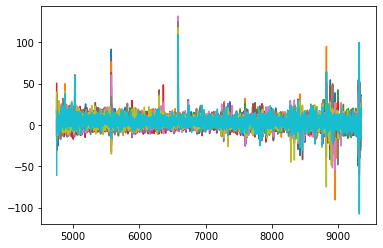

In [335]:
function(wavelength, np.reshape(Flux250[:, 0:10], (10, 3681)), np.reshape(Error250[:, 0:10], (10, 3681)))

In [132]:
print(Flux250.shape)

print(np.reshape(Flux250[:, 0:10], (10, 3681)).shape)

(3681, 16134)
(10, 3681)


When using specutils the wavelength must be same size or one greater than flux array?? Spectrum1D - can increase dimensions??
